In [1]:
import numpy as np
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal, kde
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

%matplotlib inline
sns.set(palette='husl')

seed = 7
np.random.seed(seed)
tf.set_random_seed(seed)

In [2]:
n_trials = 1000
n_samples = 10000

In [3]:
# Generate random means
def generate_means(n=3, lo=-3, hi=3):
    return np.random.uniform(lo, hi, size=n)

# Generate random positive definite covariance matrix
def generate_covariance(n=3):
    m = np.random.random(size=(n, n))
    m = m.dot(m.T) # symmetric
    m += n*np.eye(n) * 0.01
    return m

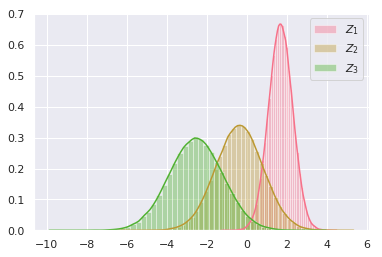

In [4]:
means = generate_means()
cov = generate_covariance()

mvn = multivariate_normal(means, cov)

N = 100000
x = mvn.rvs(N)
ns = x[:,0]
s = x[:,1]
a = x[:,2]

sns.distplot(s.reshape(-1), label='$Z_1$')
sns.distplot(a.reshape(-1), label='$Z_2$')
sns.distplot(ns.reshape(-1), label='$Z_3$')

plt.legend()
plt.show()

In [5]:
# test
x = mvn.rvs(n_samples)
x1 = x[:,0]
x2 = x[:,1:]

x1_mean = np.mean(x1, keepdims=True).T
x2_mean = np.mean(x2, axis=0, keepdims=True).T

# np.cov expects rows to be variables and columns to be observations
cov = np.cov(x1, x2, rowvar=False)
s11 = cov[0,0,np.newaxis,np.newaxis]
s12 = cov[np.newaxis,0,1:]
s21 = s12.T
s22 = cov[1:,1:]
cov_test = np.vstack([np.hstack([s11, s12]), np.hstack([s21, s22])])
assert np.allclose(cov, cov_test), 'sub covariances are messed up'

In [6]:
# Take random sample x2, x3 from mvn and keep fixed, we will use these to calculate p(x1 | x2, x3)
def conditional_mean(x2sample):
    e_mean = x1_mean + s12.dot(np.linalg.inv(s22)).dot(x2sample - x2_mean)
    e_mean = e_mean.ravel()
    assert e_mean.shape == (1,), 'Mean has wrong shape: {} for 1-dimensional distribution'.format(e_mean.shape)
    return e_mean

def conditional_var():
    e_var = s11 - s12.dot(np.linalg.inv(s22)).dot(s21)
    e_var = e_var.ravel()
    assert e_var.shape == (1,), 'Var has wrong shape: {} for 1-dimensional distribution'.format(e_var.shape)
    return e_var

x2sample = x2[0].reshape(2,1)
e_mean = conditional_mean(x2sample)
e_var = conditional_var()
print('Expected mean: ', e_mean)
print('Expected variance: ', e_var)

Expected mean:  [-1.8018]
Expected variance:  [0.2651]


# Calculate mean/var given PDF

In [7]:
xs = np.linspace(e_mean - 100, e_mean + 100, n_samples)
pos = np.empty(xs.shape + (3,))
pos[:,0] = xs
pos[:,1] = x2sample[0]
pos[:,2] = x2sample[1]
pdf = mvn.pdf(pos)
pdf /= np.sum(pdf)

def calc_mean(xs, pdf):
    return np.sum(xs.dot(pdf))

def calc_var(xs, pdf):
    mean = calc_mean(xs, pdf)
    diff = xs - mean
    var = np.sum((diff**2).dot(pdf))
    return var

c_mean = calc_mean(xs, pdf)
c_var = calc_var(xs, pdf)
print('Mean given pdf: ', c_mean)
print('Var given pdf: ', c_var)

mean_diff = abs(c_mean - e_mean)
var_diff = abs(c_var - e_var)
assert 0.2 > mean_diff, mean_diff
assert 0.2 > var_diff, var_diff

Mean given pdf:  -1.7923184651400876
Var given pdf:  0.25823743748928685


In [8]:
def normal_univariate_pdf(m, v, z):
    return 1./np.sqrt(2*np.pi*v) * np.exp(-(z-m)**2/(2*v))

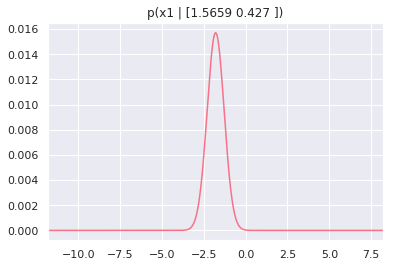

In [9]:
plt.plot(xs, pdf)
plt.xlim([e_mean-10, e_mean+10])
plt.title('p(x1 | {})'.format(x2sample.ravel()))
plt.show()

# CVAE

In [10]:
def softplus_inverse(x):
    return tf.log(tf.expm1(x))

def make_encoder(data, condition, code_size, drop_prob=0, training=False):
    x = tf.concat(axis=1, values=[data, condition])
    x = tf.layers.dense(x, 100, tf.nn.elu)
    x = tf.layers.dense(x, 100, tf.nn.elu)
    loc = tf.layers.dense(x, code_size)
    scale = tf.layers.dense(x, code_size)
    scale = tf.nn.softplus(scale + softplus_inverse(1.0))
    return tfd.MultivariateNormalDiag(loc, scale)

def make_prior(code_size, mixture_components=1):
    if mixture_components == 1:
        return tfd.MultivariateNormalDiag(
            loc=tf.zeros([code_size]), 
            scale_identity_multiplier=1.0)
    
    loc = tf.get_variable(name="loc", shape=[mixture_components, code_size])
    raw_scale_diag = tf.get_variable(
      name="raw_scale_diag", shape=[mixture_components, code_size])
    mixture_logits = tf.get_variable(
      name="mixture_logits", shape=[mixture_components])

    return tfd.MixtureSameFamily(
      components_distribution=tfd.MultivariateNormalDiag(
          loc=loc,
          scale_diag=tf.nn.softplus(raw_scale_diag)),
      mixture_distribution=tfd.Categorical(logits=mixture_logits),
      name="prior")

def make_decoder(code, condition, data_shape, drop_prob=0, training=False):
    x = tf.concat(axis=1, values=[code, condition])
    x = tf.layers.dense(x, 100, tf.nn.elu)
    x = tf.layers.dense(x, 100, tf.nn.elu)
    mu = tf.layers.dense(x, np.prod(data_shape))
    mu = tf.reshape(mu, [-1] + data_shape)
    sigma = tf.layers.dense(x, np.prod(data_shape))
    sigma = tf.reshape(sigma, [-1] + data_shape)
    sigma = tf.nn.softplus(sigma + softplus_inverse(1.0))
    out = tfd.Normal(mu, sigma)
    return tfd.Independent(out, len(data_shape))

make_prior = tf.make_template('prior', make_prior)
make_encoder = tf.make_template('encoder', make_encoder)
make_decoder = tf.make_template('decoder', make_decoder)

# Training

In [11]:
batch_size = 10000

n_states = n_inputs = n_outputs = n_actions = 1
n_conditions = n_actions + n_states
n_codings = 1

In [12]:
X = tf.placeholder(tf.float32, [None, n_inputs], name='X')
COND = tf.placeholder(tf.float32, [None, n_conditions], name='COND')
Z = tf.placeholder(tf.float32, [n_trials, 1], name='Z')
TRAINING = tf.Variable(False, trainable=False, name='training')
    
mixture_components = 1
prior = make_prior(code_size=n_codings, mixture_components=mixture_components)
posterior = make_encoder(X, COND, code_size=n_codings, drop_prob=0.2, training=TRAINING)
code = posterior.sample()

likelihood = make_decoder(code, COND, [n_outputs], drop_prob=0.2, training=TRAINING).log_prob(X)
distortion = -likelihood
if mixture_components > 1 :
    divergence = posterior.log_prob(code) - prior.log_prob(code)
else:
    divergence = tfd.kl_divergence(posterior, prior)

elbo = tf.reduce_mean(-(divergence + distortion))
loss = -elbo

In [13]:
NUM_STEPS = 10000

global_step = tf.train.get_or_create_global_step()
learning_rate = tf.train.cosine_decay(1e-5, global_step, NUM_STEPS)
    
optimize = tf.train.AdamOptimizer(learning_rate).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

------------------------
Step: 1000. Loss: 1.5190
Sampled mean (over 1000 prior samples): -2.0572
Expected: -3.9604
Diff: 1.9032


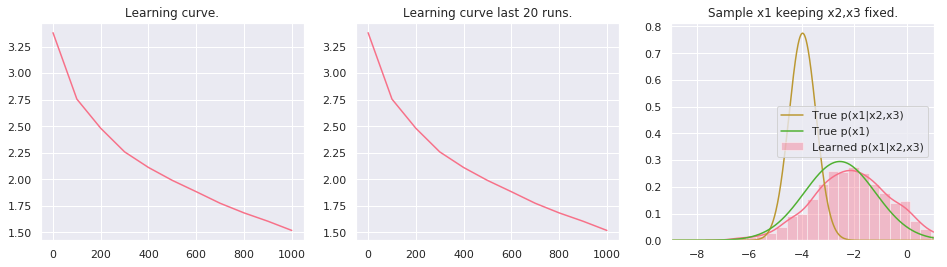

------------------------
Step: 2000. Loss: 1.0500
Sampled mean (over 1000 prior samples): -3.3247
Expected: -3.5428
Diff: 0.2181


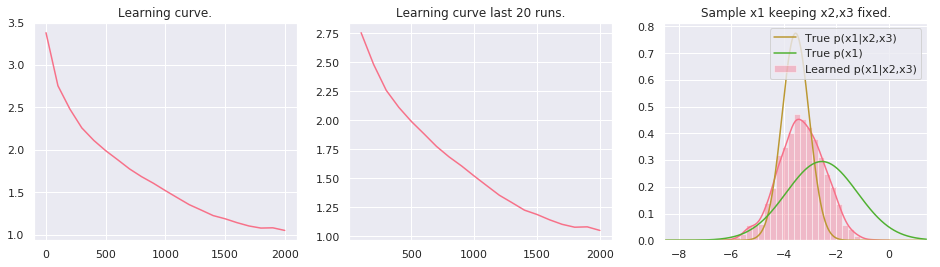

------------------------
Step: 3000. Loss: 0.9605
Sampled mean (over 1000 prior samples): -2.0099
Expected: -2.5114
Diff: 0.5015


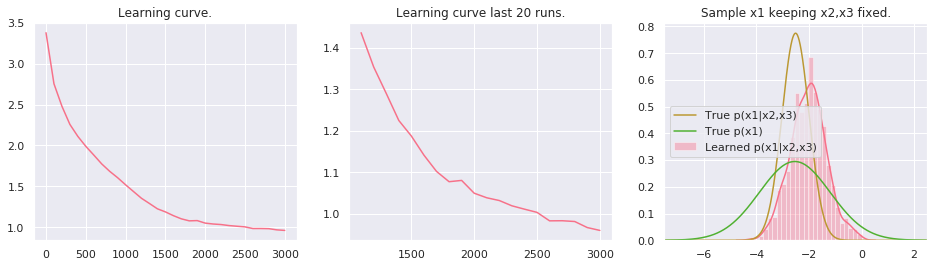

------------------------
Step: 4000. Loss: 0.8867
Sampled mean (over 1000 prior samples): -3.1662
Expected: -3.2187
Diff: 0.0526


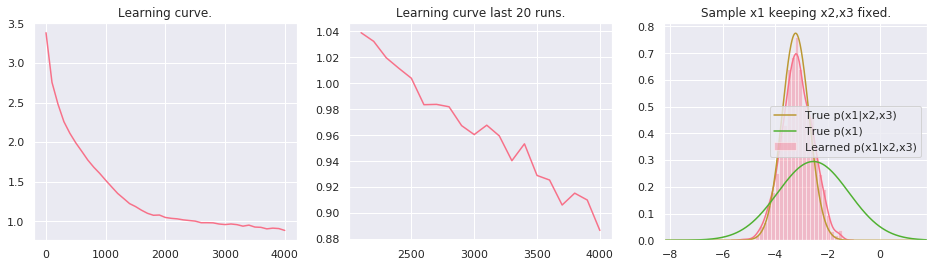

------------------------
Step: 5000. Loss: 0.8262
Sampled mean (over 1000 prior samples): -1.6641
Expected: -2.0179
Diff: 0.3538


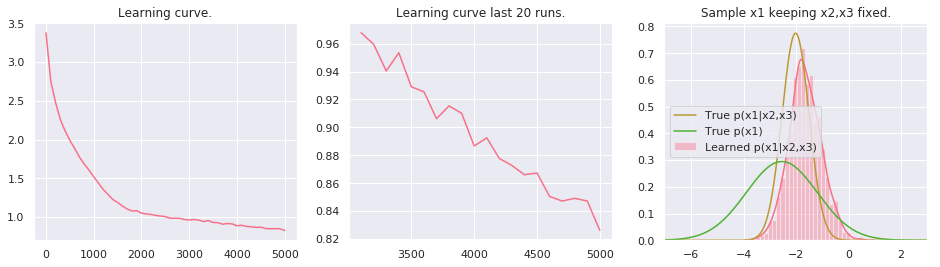

------------------------
Step: 6000. Loss: 0.7835
Sampled mean (over 1000 prior samples): -1.9199
Expected: -2.1824
Diff: 0.2625


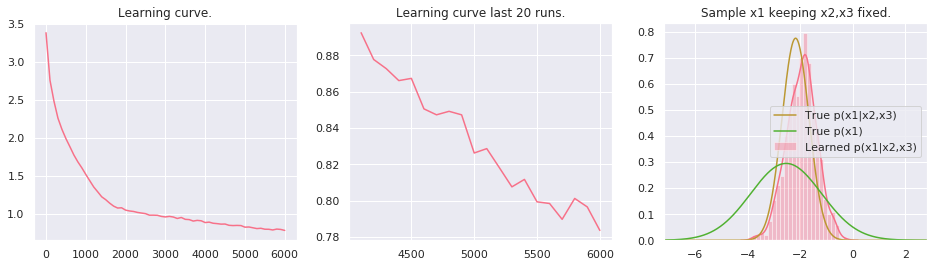

------------------------
Step: 7000. Loss: 0.7585
Sampled mean (over 1000 prior samples): -2.5015
Expected: -2.4887
Diff: -0.0128


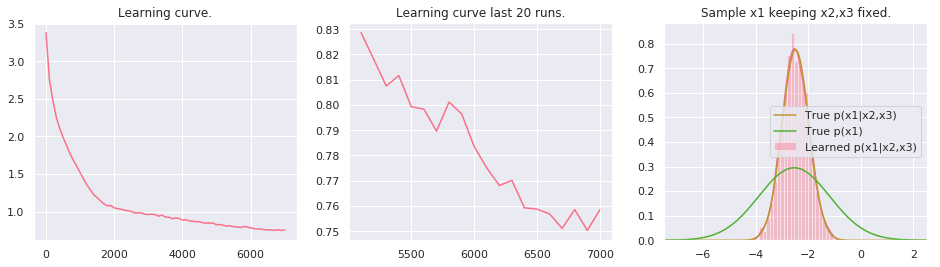

------------------------
Step: 8000. Loss: 0.7398
Sampled mean (over 1000 prior samples): -2.5782
Expected: -2.5741
Diff: -0.0042


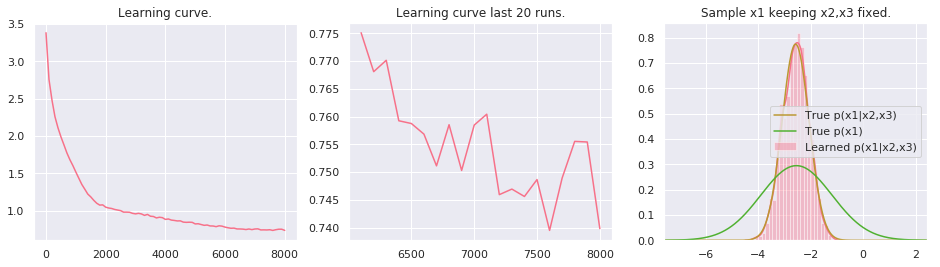

------------------------
Step: 9000. Loss: 0.7428
Sampled mean (over 1000 prior samples): -2.4974
Expected: -2.4872
Diff: -0.0101


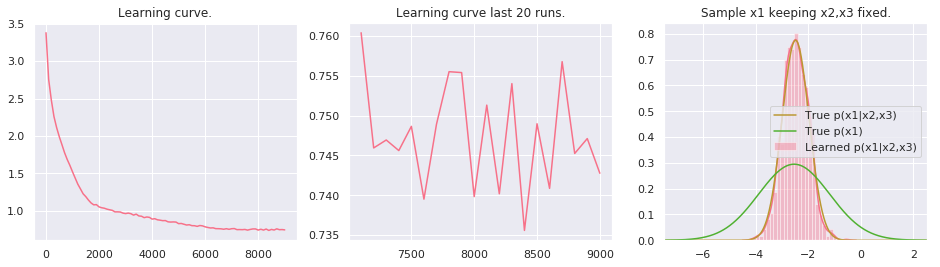

------------------------
Step: 10000. Loss: 0.7258
Sampled mean (over 1000 prior samples): -1.0633
Expected: -1.0699
Diff: 0.0066


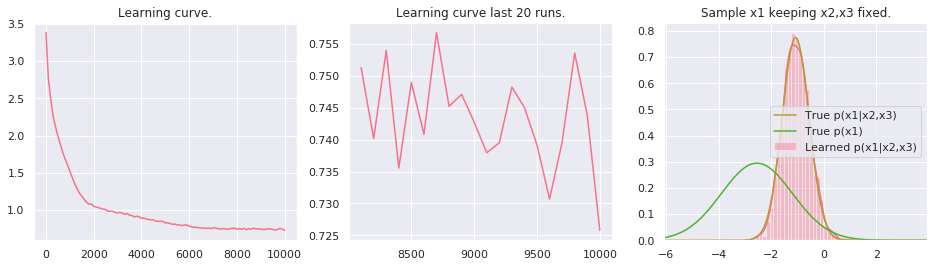

In [14]:
global_step = []
losses = []

d = make_decoder(prior.sample(n_trials), COND, [n_outputs])
decoder_samples = d.sample()

pdf_samples = make_decoder(prior.sample(n_trials), COND, [n_outputs]).sample()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(NUM_STEPS+1):
    x = mvn.rvs(batch_size*n_inputs).reshape([batch_size, n_inputs, 3])
    ns = x[:,:,0]
    s = x[:,:,1]
    a = x[:,:,2]
    cond = np.hstack([s, a])
    
    feed_dict = {X: ns, COND: cond, TRAINING: True}
    sess.run(optimize, feed_dict=feed_dict)
    if i % 100 == 0:
        curr_loss = sess.run(loss, feed_dict=feed_dict)
        global_step.append(i)
        losses.append(curr_loss)
    if i % 1000 == 0 and i > 0:
        print('------------------------')
        print('Step: {}. Loss: {:.4f}'.format(i, curr_loss))
        plt.figure(figsize=(16,4))
        ax = plt.subplot(131)
        ax.plot(global_step, losses)
        ax.set_title('Learning curve.')

        ax = plt.subplot(132)
        last = 20
        ax.plot(global_step[-last:], losses[-last:])
        ax.set_title('Learning curve last {} runs.'.format(last))
        
        ax = plt.subplot(133)
        _, s, a = mvn.rvs()
        c = np.hstack([s, a]).reshape(2,1)
        cm = conditional_mean(c)
        z = np.linspace(cm-5, cm+5, n_trials)

        samples = sess.run(pdf_samples, 
                           {COND: np.tile(c.T, [n_trials, 1])})
        sns.distplot(samples, label='Learned p(x1|x2,x3)', ax=ax)

        pos = np.empty((n_trials, 3))
        pos[:,0] = z.ravel()
        pos[:,1] = s
        pos[:,2] = a

        #pdf = mvn.pdf(pos)
        pdf = normal_univariate_pdf(cm, conditional_var(), z)
        ax.plot(z, pdf, label='True p(x1|x2,x3)')
            
        m, v = means[0], cov[0,0]
        pdf = normal_univariate_pdf(m, v, z)
        ax.plot(z, pdf, label='True p(x1)')
        ax.set_title('Sample x1 keeping x2,x3 fixed.')
        ax.legend()
        
        d = make_decoder(prior.sample(n_trials), COND, [n_outputs])
        mean = sess.run(d.mean(), {COND: np.tile(c.T, [n_trials, 1])})
        print('Sampled mean (over {} prior samples): {:.4f}'.format(n_trials, np.mean(mean)))
        print('Expected: {:.4f}'.format(cm[0]))
        print('Diff: {:.4f}'.format((np.mean(mean) - cm[0])))

        ax.set_xlim(cm-5, cm+5)
        plt.show()

# Learned p(x1 | x2, x3)

In [15]:
_, s, a = mvn.rvs()
c = np.hstack([s, a]).reshape(2,1)
cm = conditional_mean(c)
        
N = 1000

d = make_decoder(prior.sample(N), COND, [n_outputs])
mean, samples = sess.run([d.mean(), d.sample(N)], {COND: np.tile(c.T, [N, 1])})
print('Sampled mean: {:.4f}, expected: {:.4f}'.format(np.mean(samples), cm[-1]))
print('Sampled var: {:.4f}, expected: {:.4f}'.format(np.var(samples), conditional_var()[-1]))

Sampled mean: -4.3308, expected: -4.3011
Sampled var: 0.2615, expected: 0.2651


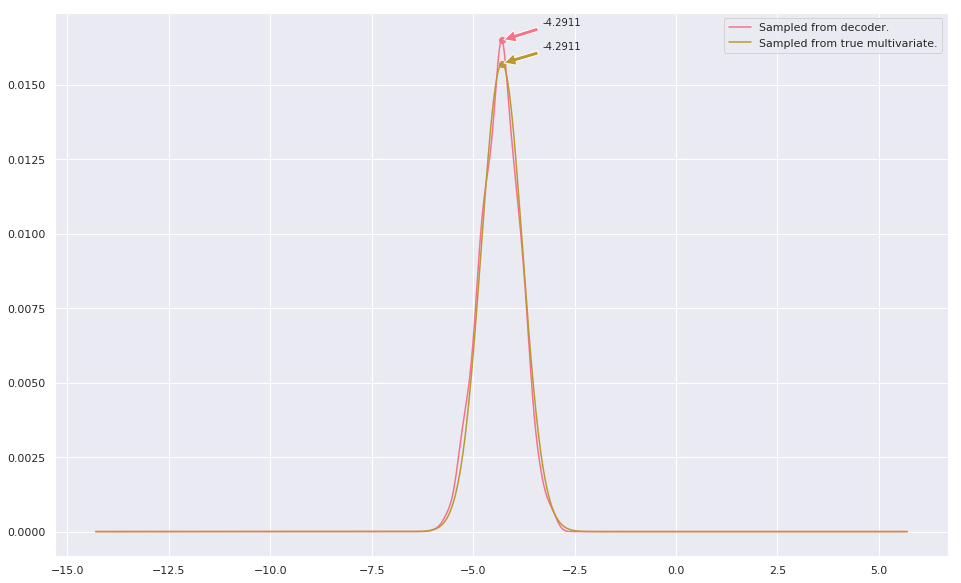

In [16]:
fig = plt.figure(figsize=(16,10))
ax = plt.gca()

z = np.linspace(cm-10, cm+10, N)
Z = tf.placeholder(tf.float32, N, name='COND')

d = make_decoder(prior.sample(N), COND, [n_outputs])
samples = sess.run(d.sample(), {Z: z, COND: np.tile(c.T, [N, 1])})

pdf = kde.gaussian_kde(samples.reshape(-1))(z)
pdf /= np.sum(pdf)
plt.plot(z, pdf, label='Sampled from decoder.')

argmax = np.argmax(pdf)
color = sns.color_palette()[0]
plt.scatter(z[argmax], pdf[argmax], marker='o', color=color)
xypos = np.array([z[argmax], pdf[argmax]])
xypos_text = xypos + [np.ptp(z) * 0.05, np.max(pdf) * 0.03]
ax.annotate('{:.4f}'.format(z[argmax]), xy=xypos, xytext=xypos_text,
            arrowprops=dict(facecolor=color, shrink=0.05))


pos = np.empty((N, 3))
pos[:,0] = z
pos[:,1] = c[0]
pos[:,2] = c[1]

pdf = mvn.pdf(pos)
pdf /= np.sum(pdf)
plt.plot(z, pdf, label='Sampled from true multivariate.')

argmax = np.argmax(pdf)
color = sns.color_palette()[1]
plt.scatter(z[argmax], pdf[argmax], marker='o', color=color)
xypos = np.array([z[argmax], pdf[argmax]])
xypos_text = xypos + [np.ptp(z) * 0.05, np.max(pdf) * 0.03]
ax.annotate('{:.4f}'.format(z[argmax]), xy=xypos, xytext=xypos_text,
            arrowprops=dict(facecolor=color, shrink=0.05))
plt.legend()

plt.show()

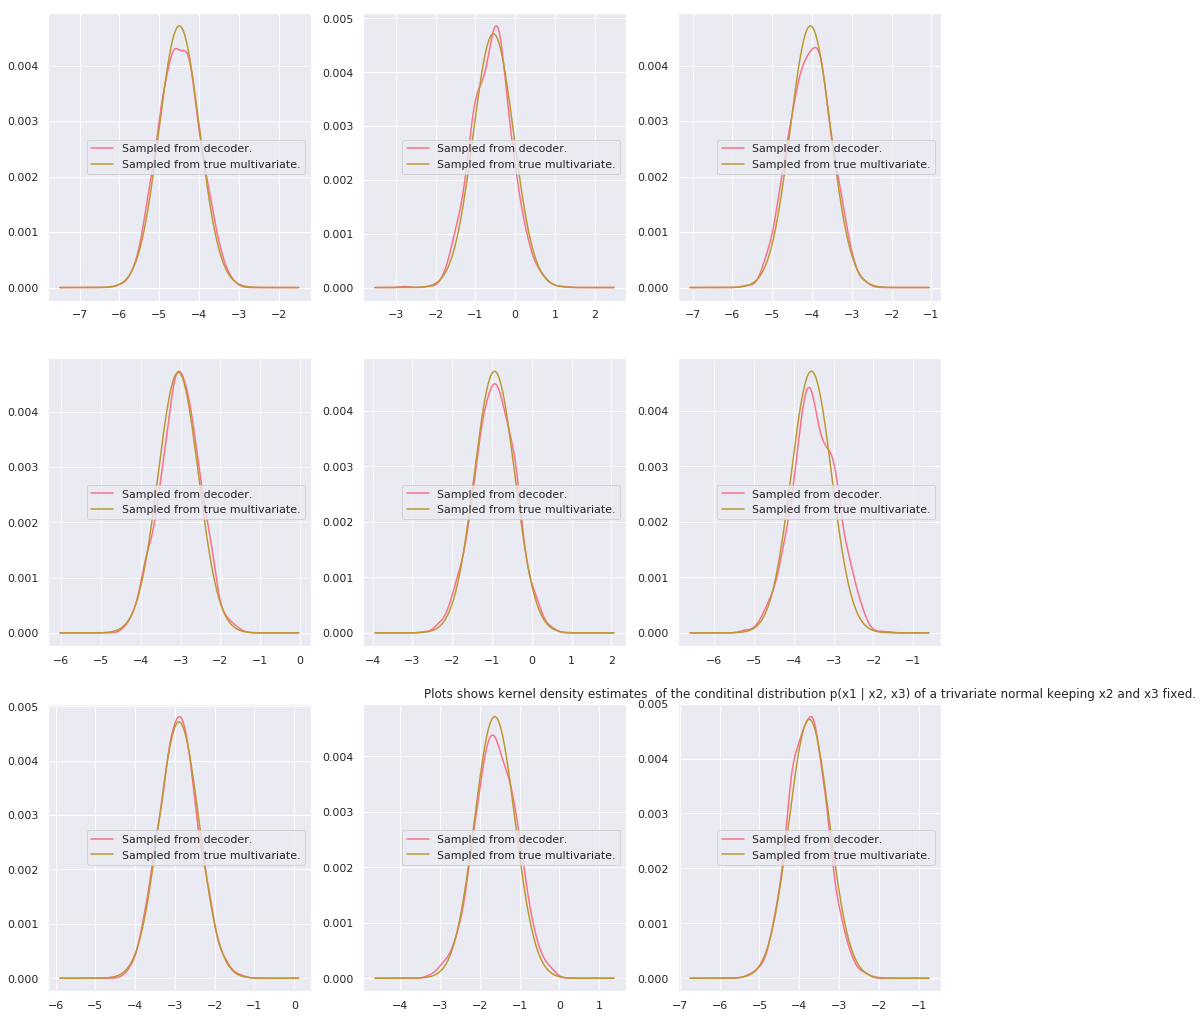

In [24]:
rows, cols = 3, 3

fig = plt.figure(figsize=(16,6*rows))
Z = tf.placeholder(tf.float32, z.shape, name='COND')

n_subplots = (rows, cols)
row = 0
for i in range(np.prod(n_subplots)):
    if i > cols:
        row += 1
    col = i % (cols)
    ax = plt.subplot(rows, cols, i+1)
    
    _, s, a = mvn.rvs()
    c = np.hstack([s, a]).reshape(2,1)
    cm = conditional_mean(c)

    z = np.linspace(cm - 3, cm + 3, N)

    samples = sess.run(d.sample(), {Z: z, COND: np.tile(c.T, [N, 1])})
    pdf = kde.gaussian_kde(samples.reshape(-1))(z)
    pdf /= np.sum(pdf)
    plt.plot(z, pdf, label='Sampled from decoder.')
    
    pos = np.empty((N, 3))
    pos[:,0] = z
    pos[:,1] = c[0]
    pos[:,2] = c[1]

    pdf = mvn.pdf(pos)
    pdf /= np.sum(pdf)
    ax.plot(z, pdf, label='Sampled from true multivariate.')
    plt.legend()
plt.show()

### Figure shows kernel density estimates  of the conditinal distribution p(x1 | x2, x3) of a trivariate normal  where x2 and x3 are fixed in each plot.

# Boxplot

In [18]:
def boxplot(x_data, y_data, base_color='#77CCBB', median_color='#FC7382', x_label='', y_label='', title=''):
    _, ax = plt.subplots(figsize=(16,10), facecolor='w')

    ax.boxplot(y_data,
               medianprops = {'color': median_color},
               boxprops = {'color': base_color},
               whiskerprops = {'color': base_color},
               capprops = {'color': base_color},
               showfliers=False)

    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    return ax

In [19]:
def sample_and_plot(mvn, n_trials, n_samples=30):
    x = mvn.rvs(n_inputs*n_samples).reshape(n_samples, n_inputs, 3)
    ns = x[:,:,0]
    s = x[:,:,1]
    a = x[:,:,2]
    outputs = np.empty((n_samples, n_trials, n_outputs))

    for i in range(n_samples):
        desired_condition = np.tile(np.hstack([s[i], a[i]]), [n_trials, 1])
        samples = sess.run(decoder_samples, feed_dict={COND: desired_condition})
        outputs[i] = samples.reshape(n_trials, -1)
    
    ax = boxplot(range(len(outputs)), outputs[:,:,0].T, x_label='Sample#', y_label='Value')
    colors = sns.color_palette("Set1", n_samples)
    y = np.array([conditional_mean(np.array([s[i], a[i]]).reshape(2, n_inputs)) 
                  for i in range(n_samples)])
    plt.scatter(range(1, n_samples+1), y, marker='o', label='Expected conditional mean, eg E[z1|z2,z3]', color=colors)
    plt.legend()
    plt.show()

# Box plot

Boxplot showing the confidence of predicted means and the actual expected mean are plotted as dots.

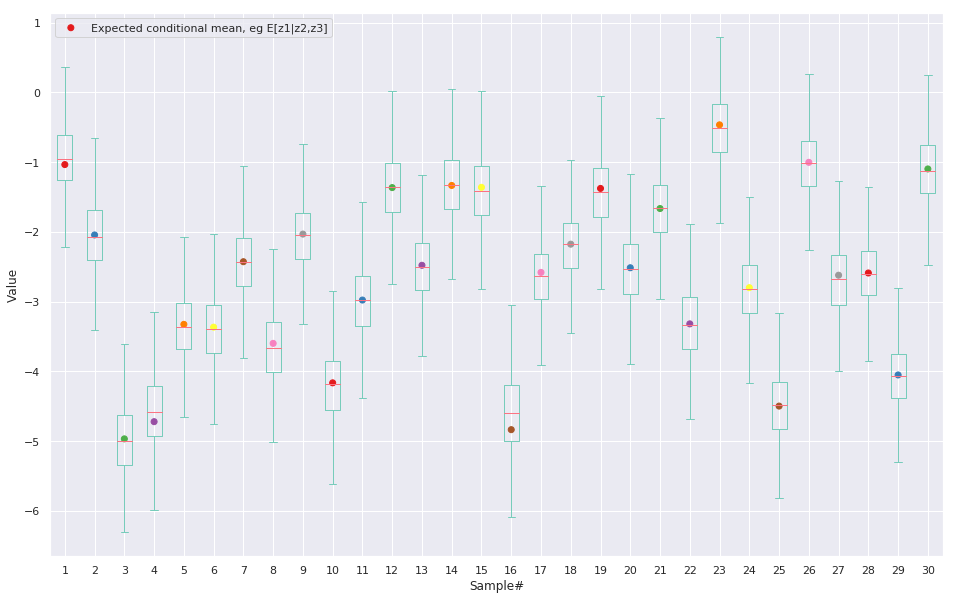

In [20]:
sample_and_plot(mvn, n_trials=decoder_samples.shape[0])